In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from venny4py.venny4py import *

## Exploratory Analysis

### Initial Visualization

In [72]:
df = pd.read_csv('data.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [73]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [75]:
for i in df.isnull().sum():
    if i != 0:
        print('We have a null entry')

### Visualizing Distribution

<Axes: ylabel='JobRole'>

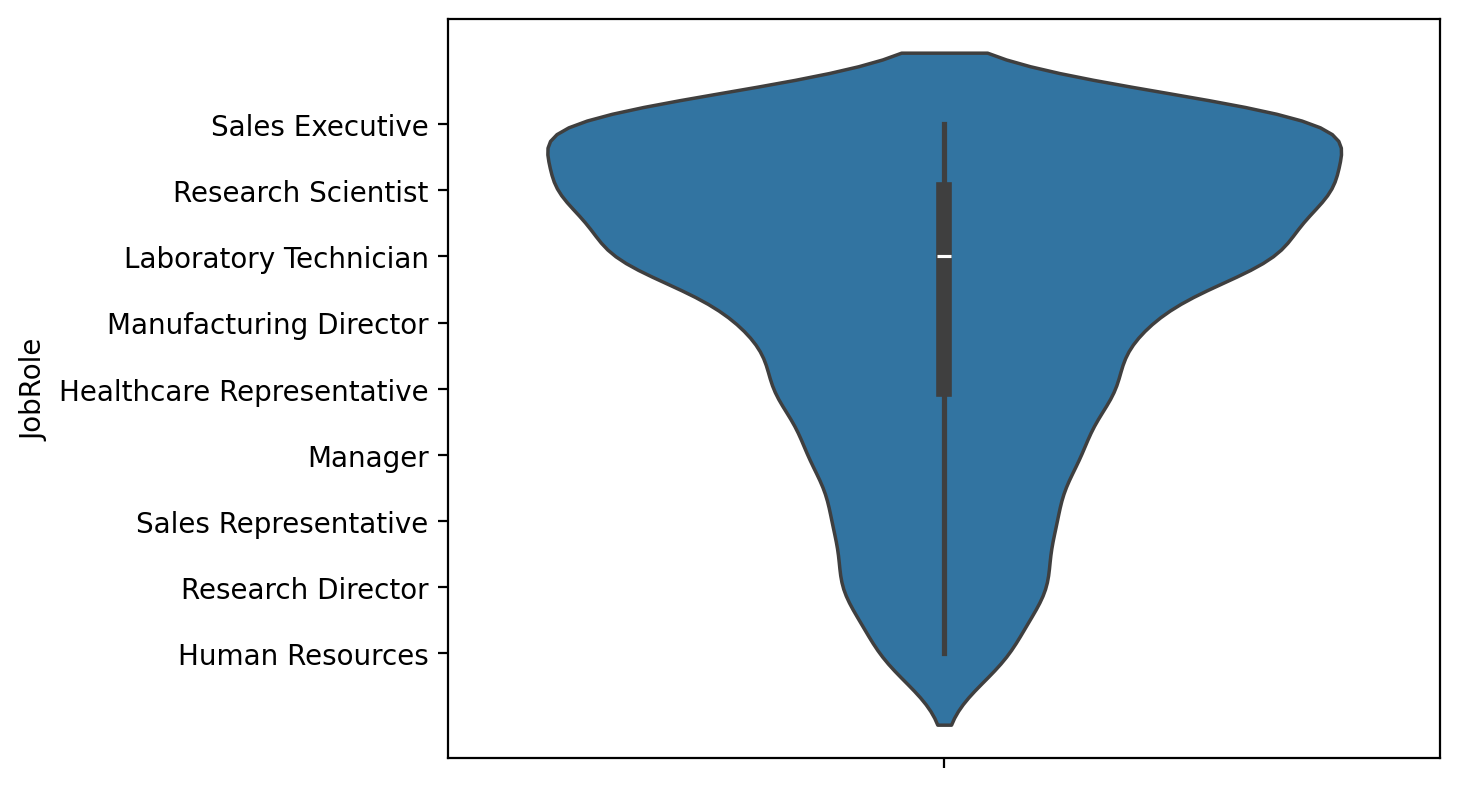

In [76]:
sns.violinplot(df['JobRole'])

### Relation of Education Field and Attrition to Income

In [77]:
df[['MonthlyIncome', 'EducationField']].groupby(by=['EducationField']).mean()

,MonthlyIncome
EducationField,
Human Resources,7241.148148
Life Sciences,6463.288779
Marketing,7348.584906
Medical,6510.036638
Other,6071.548780
Technical Degree,5758.303030


In [78]:
df[['Attrition', 'MonthlyIncome']].groupby(by=['Attrition']).mean()

,MonthlyIncome
Attrition,
No,6832.739659
Yes,4787.092827


In [79]:
df[['Attrition', 'EducationField', 'MonthlyIncome']].groupby(by=['Attrition', 'EducationField']).mean()

MonthlyIncome
Attrition EducationField                 
No        Human Resources     8579.950000
          Life Sciences       6775.437137
          Marketing           7569.774194
          Medical             6800.805486
          Other               6422.704225
          Technical Degree    6284.810000
Yes       Human Resources     3416.000000
          Life Sciences       4650.022472
          Marketing           6564.942857
          Medical             4659.269841
          Other               3805.000000
          Technical Degree    4112.968750

## Modelling

### Normalizing

In [80]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
print(numerical_columns)

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


In [81]:
scaler = StandardScaler()
fit = scaler.fit(df[numerical_columns])
df[numerical_columns] = fit.transform(df[numerical_columns])
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.446350,Yes,Travel_Rarely,0.742527,Sales,-1.010909,-0.891688,Life Sciences,0.0,-1.701283,...,-1.584178,0.0,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834
1,1.322365,No,Travel_Frequently,-1.297775,Research & Development,-0.147150,-1.868426,Life Sciences,0.0,-1.699621,...,1.191438,0.0,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541
2,0.008343,Yes,Travel_Rarely,1.414363,Research & Development,-0.887515,-0.891688,Other,0.0,-1.696298,...,-0.658973,0.0,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935
3,-0.429664,No,Travel_Frequently,1.461466,Research & Development,-0.764121,1.061787,Life Sciences,0.0,-1.694636,...,0.266233,0.0,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935
4,-1.086676,No,Travel_Rarely,-0.524295,Research & Development,-0.887515,-1.868426,Medical,0.0,-1.691313,...,1.191438,0.0,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227


### Encoding

In [82]:
categorical_columns = df.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


In [83]:
encoder = LabelEncoder()
df[categorical_columns] = df[categorical_columns].apply(encoder.fit_transform)

if df.select_dtypes(include=['object']).columns.array.size == 0:
    print("Categorical data encoded!")

df.head()

Categorical data encoded!


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.446350,1,2,0.742527,2,-1.010909,-0.891688,1,0.0,-1.701283,...,-1.584178,0.0,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834
1,1.322365,0,1,-1.297775,1,-0.147150,-1.868426,1,0.0,-1.699621,...,1.191438,0.0,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541
2,0.008343,1,2,1.414363,1,-0.887515,-0.891688,4,0.0,-1.696298,...,-0.658973,0.0,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935
3,-0.429664,0,1,1.461466,1,-0.764121,1.061787,1,0.0,-1.694636,...,0.266233,0.0,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935
4,-1.086676,0,2,-0.524295,1,-0.887515,-1.868426,3,0.0,-1.691313,...,1.191438,0.0,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227


In [84]:
constant_columns = []
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) == 1:
        constant_columns.append(column)

df.drop(columns=constant_columns, inplace=True)

print("Constant columns dropped:", constant_columns)

Constant columns dropped: ['EmployeeCount', 'Over18', 'StandardHours']


In [85]:
column_names = df.columns.tolist()
print(len(column_names))
print(column_names)

32
['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


### Random Forest Based on Various Feature Selection Techniques

In [86]:
column_names = df.columns.tolist()
column_names = column_names[:-1]
print(column_names)

['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion']


#### Splitting Data

In [87]:
X = df.drop(['Attrition'], axis=1).values
y = df['Attrition'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [88]:
RandomForest = RandomForestClassifier(n_estimators = 100)

In [89]:
def plot_conf_matrixes(conf1, title1, conf2, title2, conf3, title3):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.heatmap(conf1, ax=axes[0], annot=True, fmt="d")
    sns.heatmap(conf2, ax=axes[1], annot=True, fmt="d")
    sns.heatmap(conf3, ax=axes[2], annot=True, fmt="d")

    axes[0].set_title(title1)
    axes[1].set_title(title2)
    axes[2].set_title(title3)

    plt.suptitle('Confusion Matrices', fontsize=16)
    plt.tight_layout()
    plt.show()

#### Mutual Information, Anova and Smart Correlated Groups

In [90]:
MutualInformation = SelectKBest(mutual_info_classif, k=31)
Anova = SelectKBest(f_classif, k=31)
SmartCorr = SmartCorrelatedSelection(
    method='pearson',
    threshold=0.8,
    selection_method='variance',
    estimator=None
)

In [91]:
MI_RF = Pipeline(
    [('Mutual Information', MutualInformation),
     ('Random Forest', RandomForest)]
)

MI_RF.fit(X_train, y_train)
MI_RF_pred = MI_RF.predict(X_test)

MI_RF_score = MI_RF.score(X_train, y_train)
MI_RF_test = MI_RF.score(X_test, y_test)
print('Training score using mutual information',MI_RF_score)
print('Testing score using mutual information', MI_RF_test)

MI_RF_conf_matrix = confusion_matrix(y_test, MI_RF_pred)
print(classification_report(y_test, MI_RF_pred))

Training score using mutual information 1.0
Testing score using mutual information 0.8163265306122449
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       352
           1       0.75      0.13      0.23        89

    accuracy                           0.82       441
   macro avg       0.78      0.56      0.56       441
weighted avg       0.80      0.82      0.76       441



In [92]:
AN_RF = Pipeline(
    [('Anova', Anova),
     ('Random Forest', RandomForest)]
)

AN_RF.fit(X_train, y_train)
AN_RF_pred = AN_RF.predict(X_test)

AN_RF_score = AN_RF.score(X_train, y_train)
AN_RF_test = AN_RF.score(X_test, y_test)

print('Training score using Anova', AN_RF_score)
print('Testing score using Anova', AN_RF_test)

AN_RF_conf_matrix = confusion_matrix(y_test, AN_RF_pred)
print(classification_report(y_test, AN_RF_pred))

Training score using Anova 1.0
Testing score using Anova 0.8208616780045351
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       352
           1       0.81      0.15      0.25        89

    accuracy                           0.82       441
   macro avg       0.82      0.57      0.57       441
weighted avg       0.82      0.82      0.77       441



In [93]:
SC_RF = Pipeline(
    [('Smart Correlated Groups', SmartCorr),
     ('Random Forest', RandomForest)]
)

SC_RF.fit(X_train, y_train)
SC_RF_pred = SC_RF.predict(X_test)

SC_RF_score = SC_RF.score(X_train, y_train)
SC_RF_test = SC_RF.score(X_test, y_test)

print('Training score using smart correlated groups', SC_RF_score)
print('Testing score using smart correlated groups', SC_RF_test)

SC_RF_conf_matrix = confusion_matrix(y_test, SC_RF_pred)
print(classification_report(y_test, AN_RF_pred))

Training score using smart correlated groups 1.0
Testing score using smart correlated groups 0.8140589569160998
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       352
           1       0.81      0.15      0.25        89

    accuracy                           0.82       441
   macro avg       0.82      0.57      0.57       441
weighted avg       0.82      0.82      0.77       441



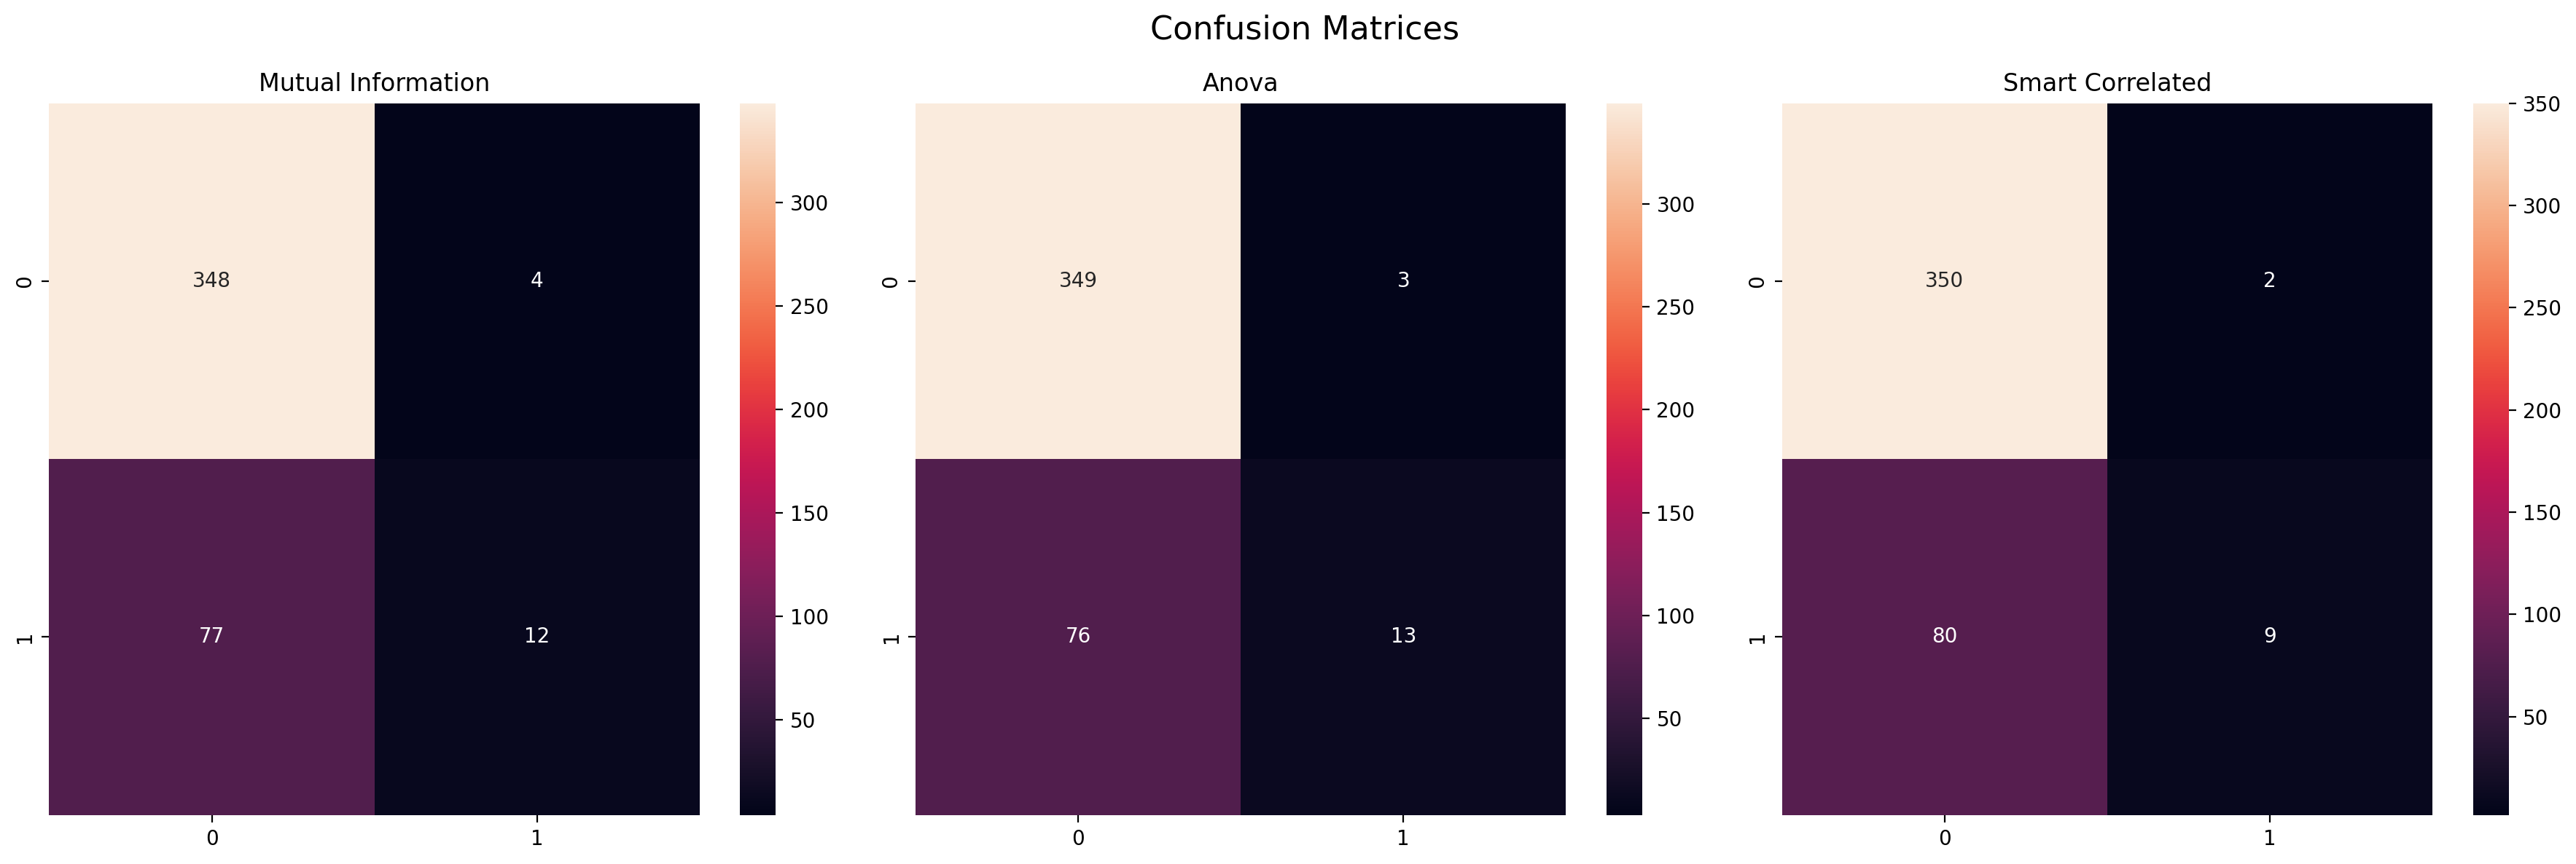

In [94]:
plot_conf_matrixes(MI_RF_conf_matrix, 'Mutual Information', AN_RF_conf_matrix, 'Anova', SC_RF_conf_matrix, 'Smart Correlated')

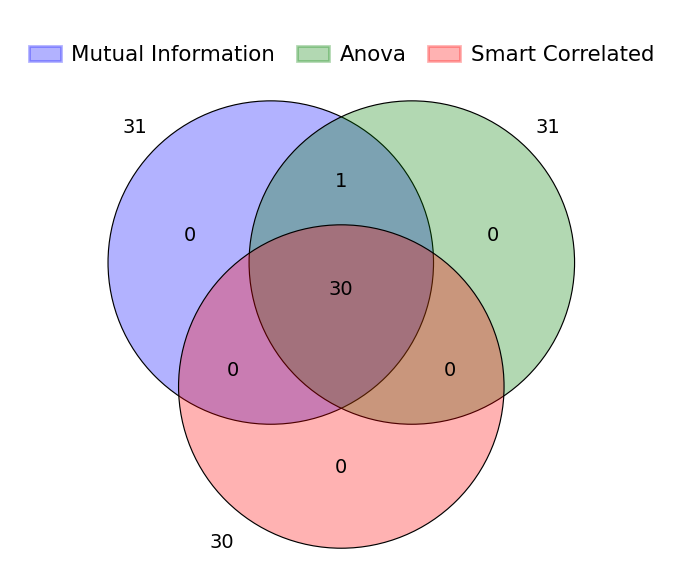

In [95]:
features_MI_RF = MI_RF[:-1].get_feature_names_out(input_features=column_names)
features_AN_RF = AN_RF[:-1].get_feature_names_out(input_features=column_names)
features_SC_RF = SC_RF[:-1].get_feature_names_out(input_features=column_names)

sets = {
    'Mutual Information': set(features_MI_RF),
    'Anova': set(features_AN_RF),
    'Smart Correlated': set(features_SC_RF)
}

venny4py(sets=sets)

In [96]:
set(features_MI_RF).intersection(features_AN_RF, features_SC_RF)

{'Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion'}

In [97]:
best_features = features_MI_RF = MI_RF[:-1].get_feature_names_out(input_features=column_names)
print(best_features)

['Age' 'Attrition' 'BusinessTravel' 'DailyRate' 'Department'
 'DistanceFromHome' 'Education' 'EducationField' 'EmployeeNumber'
 'EnvironmentSatisfaction' 'Gender' 'HourlyRate' 'JobInvolvement'
 'JobLevel' 'JobRole' 'JobSatisfaction' 'MaritalStatus' 'MonthlyIncome'
 'MonthlyRate' 'NumCompaniesWorked' 'OverTime' 'PercentSalaryHike'
 'PerformanceRating' 'RelationshipSatisfaction' 'StockOptionLevel'
 'TotalWorkingYears' 'TrainingTimesLastYear' 'WorkLifeBalance'
 'YearsAtCompany' 'YearsInCurrentRole' 'YearsSinceLastPromotion']


## Optimal Models

In [98]:
model_df = df[best_features]
model_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion
0,0.446350,1,2,0.742527,2,-1.010909,-0.891688,1,-1.701283,-0.660531,...,-1.150554,-0.426230,-1.584178,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146
1,1.322365,0,1,-1.297775,1,-0.147150,-1.868426,1,-1.699621,0.254625,...,2.129306,2.346151,1.191438,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715
2,0.008343,1,2,1.414363,1,-0.887515,-0.891688,4,-1.696298,1.169781,...,-0.057267,-0.426230,-0.658973,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146
3,-0.429664,0,1,1.461466,1,-0.764121,1.061787,1,-1.694636,1.169781,...,-1.150554,-0.426230,0.266233,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146
4,-1.086676,0,2,-0.524295,1,-0.887515,-1.868426,3,-1.691313,-1.575686,...,-0.877232,-0.426230,1.191438,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285


### Splitting Data

In [99]:
X = model_df.drop(['Attrition'], axis=1).values
y = model_df['Attrition'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Decision Tree

In [100]:
DecisionTree = DecisionTreeClassifier(random_state=1)
DecisionTree.fit(X_train, y_train)
y_pred = DecisionTree.predict(X_test)

DecisionTree_score = DecisionTree.score(X_train, y_train)
DecisionTree_test = DecisionTree.score(X_test, y_test)

DT_conf_matrix = confusion_matrix(y_test, y_pred)

print('Training Score', DecisionTree_score)
print('Testing Score', DecisionTree_test)

Training Score 1.0
Testing Score 0.7777777777777778


In [101]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       371
           1       0.33      0.37      0.35        70

    accuracy                           0.78       441
   macro avg       0.60      0.61      0.61       441
weighted avg       0.79      0.78      0.78       441



### Random Forest

In [102]:
RandomForest = RandomForestClassifier(n_estimators = 100)

RandomForest.fit(X_train, y_train)
RandomForest_score = RandomForest.score(X_train, y_train)
RandomForest_test = RandomForest.score(X_test, y_test)

y_pred = RandomForest.predict(X_test)

RF_conf_matrix = confusion_matrix(y_test, y_pred)

print('Training Score',RandomForest_score)
print('Testing Score',RandomForest_test)

Training Score 1.0
Testing Score 0.8526077097505669


In [103]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       371
           1       0.67      0.14      0.24        70

    accuracy                           0.85       441
   macro avg       0.76      0.56      0.58       441
weighted avg       0.83      0.85      0.81       441



### K-Nearest Neighbours

In [104]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

KNN_score = knn.score(X_train, y_train)
KNN_test = knn.score(X_test, y_test)

KNN_conf_matrix = confusion_matrix(y_test, y_pred)

print('Training Score', KNN_score)
print('Testing Score', KNN_test)

Training Score 0.8629737609329446
Testing Score 0.8390022675736961


In [105]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       371
           1       0.46      0.09      0.14        70

    accuracy                           0.84       441
   macro avg       0.66      0.53      0.53       441
weighted avg       0.79      0.84      0.79       441



### Confusion Matrixes

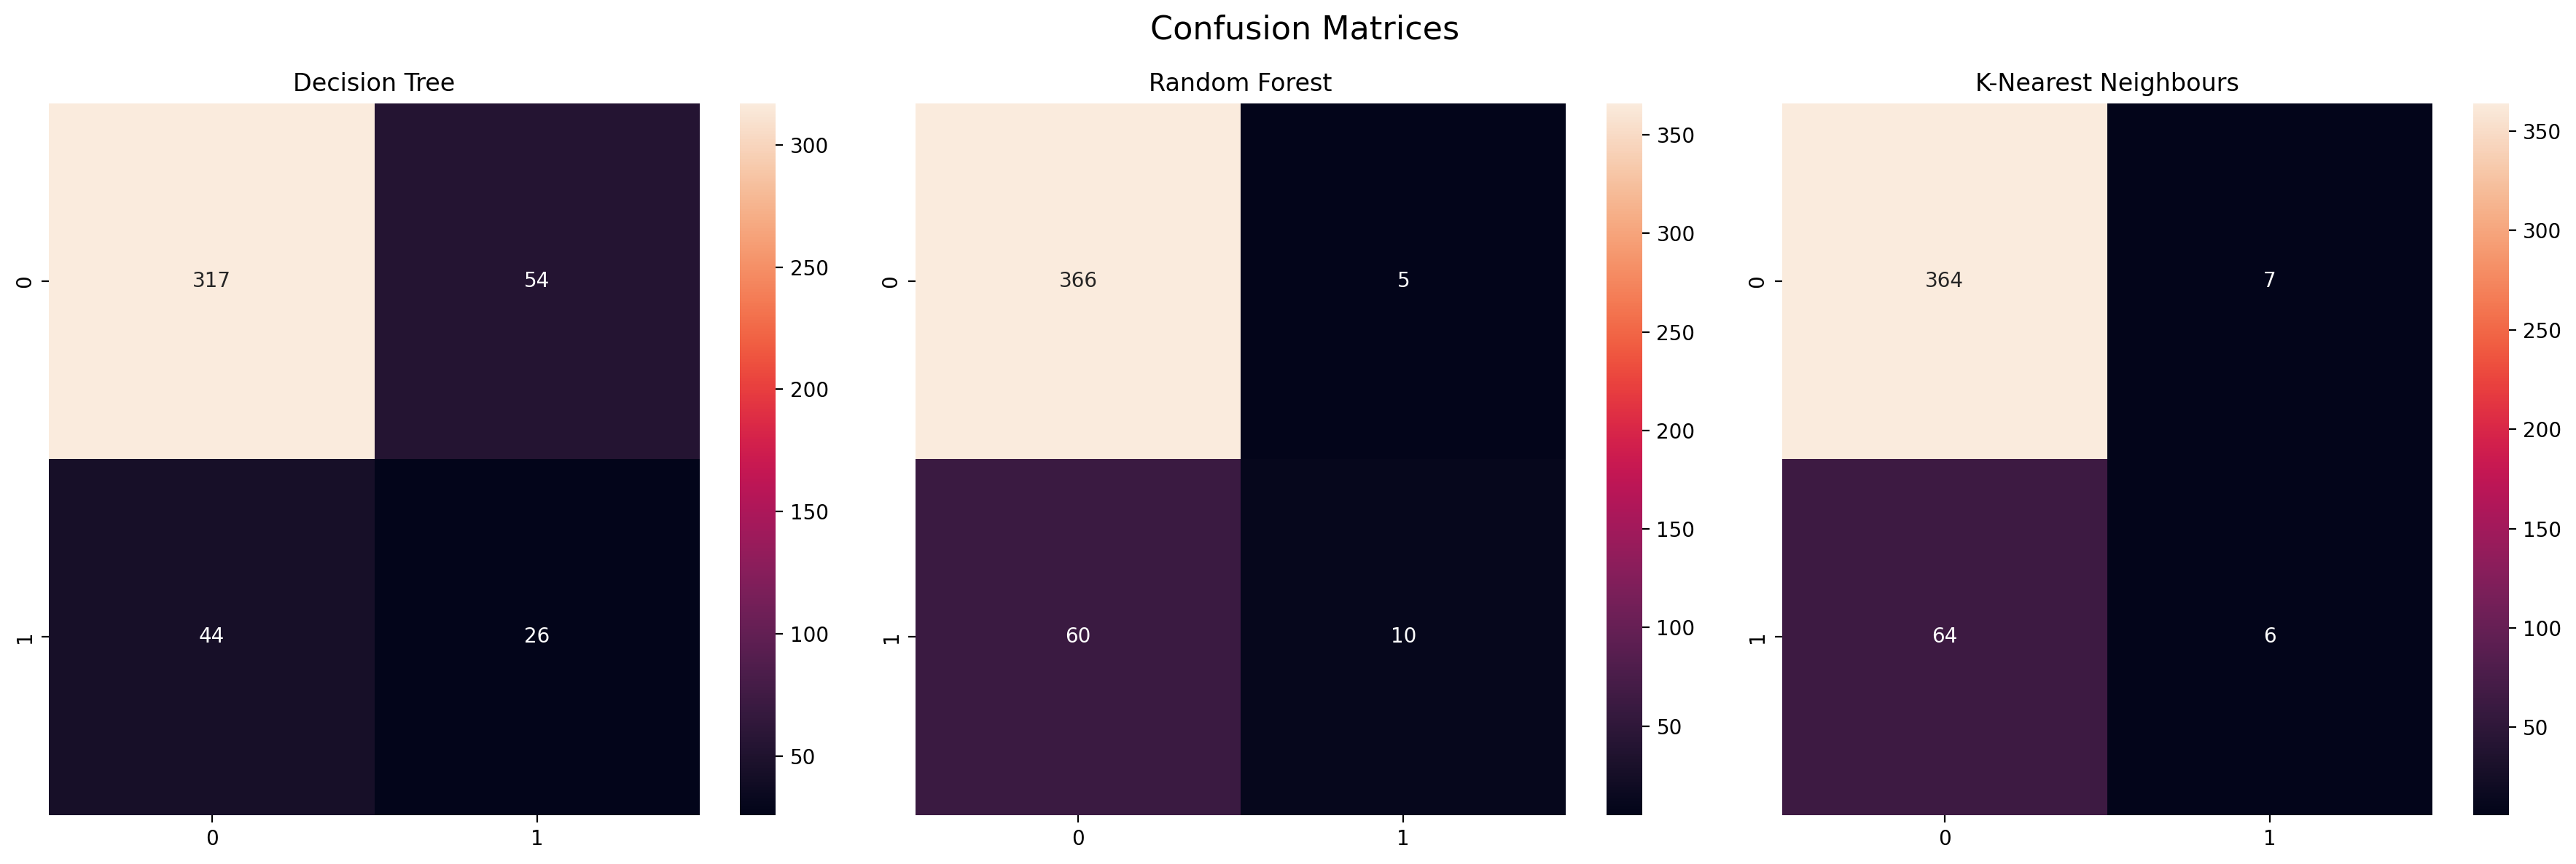

In [106]:
plot_conf_matrixes(DT_conf_matrix, 'Decision Tree', RF_conf_matrix, 'Random Forest', KNN_conf_matrix, 'K-Nearest Neighbours')